# SHAP Decision Plots
SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions). In this notebook we use simple examples to demonstrate decision plot features.

# Load the dataset and train the model
We use LightGBM and the [UCI Adult Income](https://archive.ics.uci.edu/ml/datasets/adult) dataset. The object is to predict whether an individual makes over $50K per year. There are 12 features in the dataset.

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import pickle
import shap

shap.initjs()

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


# Calculate SHAP values
We compute SHAP values and SHAP interaction values for the first 20 test observations.

In [2]:
explainer = shap.TreeExplainer(model)
print(f"Explainer expected value: {explainer.expected_value}")
select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

Explainer expected value: -2.4296968952292404


# Basic decision plot features
The first 20 test observations are plotted below.
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the model's expected value.
* The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. *This may be different than the importance ordering calculated over the entire dataset.* The decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
* Each observation is represented by a colored line. At the top of the plot, the lines strike the x-axis at their corresponding observation's predicted value. This value determines the color of the line on the spectrum.
* Moving down the plot, SHAP values for each feature are subtracted from the model's predictions. This shows how each feature contributes to the overall prediction.
* At the bottom of the plot, the observations converge at `explainer.expected_value`.

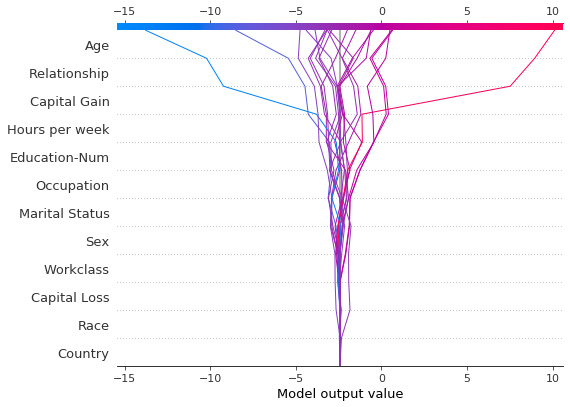

In [3]:
shap.decision_plot(explainer.expected_value, shap_values, features_display, matplotlib=True)

Like the SHAP force plot, the decision plot supports `link='logit'` to transform log odds to probabilities.

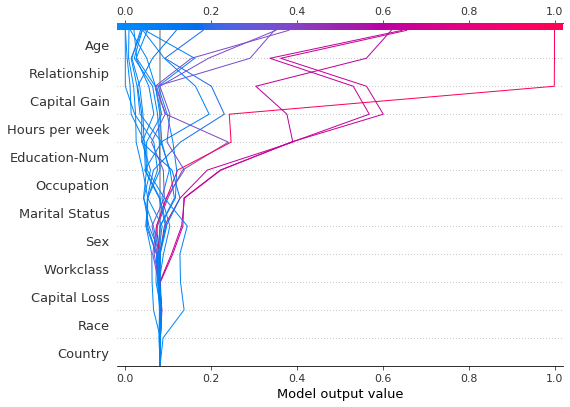

In [23]:
shap.decision_plot(explainer.expected_value, shap_values, features_display, link='logit', matplotlib=True)

We can highlight observations in the plot. Here we highlight a misclassified observation.

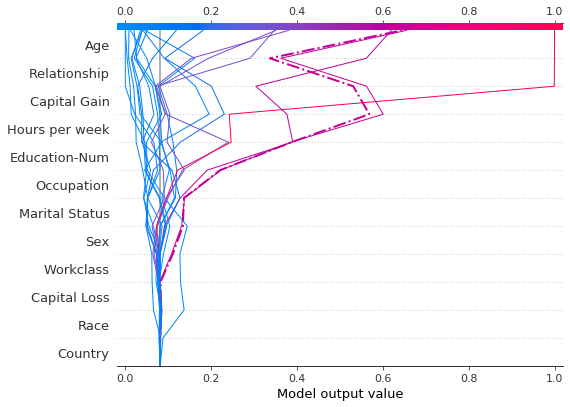

In [5]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + explainer.expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(explainer.expected_value, shap_values, features_display, 
                   highlight=misclassified, link='logit', matplotlib=True)

Let's inspect the misclassified observation by plotting it alone. The observation's line has changed shape. Why? The feature ordering on the y-axis has changed according to the feature importance for this lone observation.

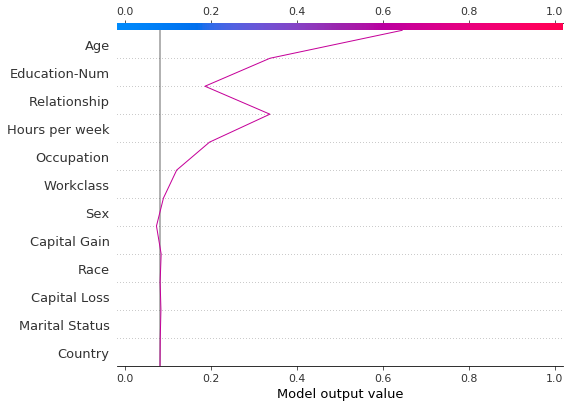

In [6]:
shap.decision_plot(explainer.expected_value, shap_values[misclassified], 
                   features_display[misclassified], link='logit', matplotlib=True)

The force plot for the same observation is shown below. In this case, the decision plot and the force plot are both effective at showing how the model arrived at its decision.

In [7]:
shap.force_plot(explainer.expected_value, shap_values[misclassified], features_display[misclassified], link='logit')

The decision plot is usually more helpful than the force plot in cases where many features are significantly involved in the model's output. The decision plot and the force plot below show the same prediction from a model trained on the [Communities and Crime Unnormalized Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized). The dataset has 101 features. The decision plot shows the effects of all of the important features clearly. In contrast, the force plot's horizontal format prevents it from showing all of the important features.

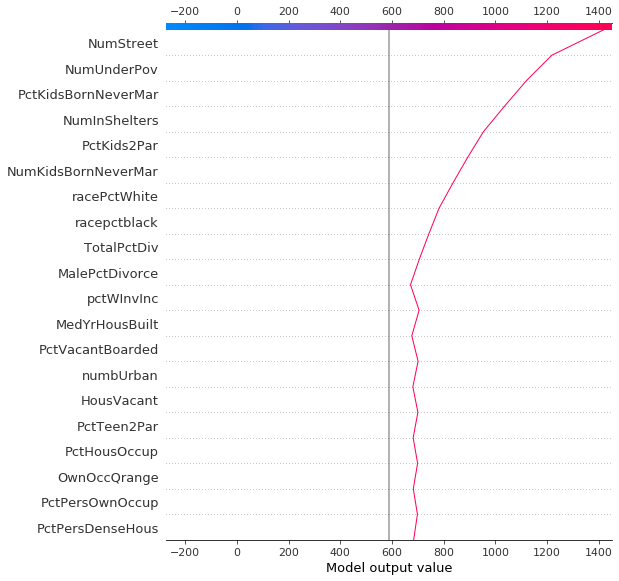

In [8]:
with open('./data/crime.pickle', 'rb') as fl:
    a, b, c = pickle.load(fl)
shap.decision_plot(a, b, c, matplotlib=True)
shap.force_plot(a, b, c)

# Feature order
The decision plot supports three ways to order features: 'importance' for feature importance (the default), 'hclust' for hierarchical clustering, and 'none' for user-defined ordering. The following plot shows 'hclust' ordering. It orders the features in a way that similar observations are grouped together.

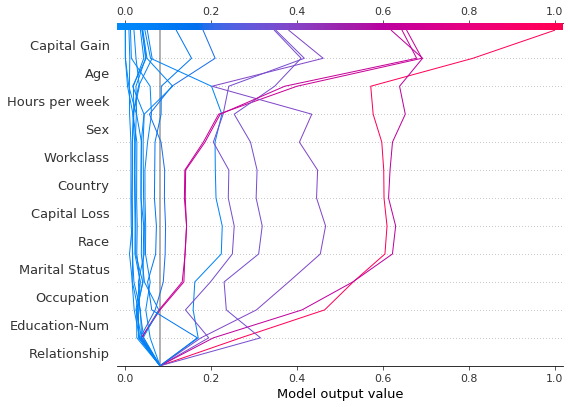

In [9]:
shap.decision_plot(explainer.expected_value, shap_values, features, 
                   feature_order='hclust', link='logit', matplotlib=True)

Feature ordering 'none' is most often used when the features are ordered beforehand. In this example, we order the features by importance over the entire test set, but we plot only the first 20 observations.

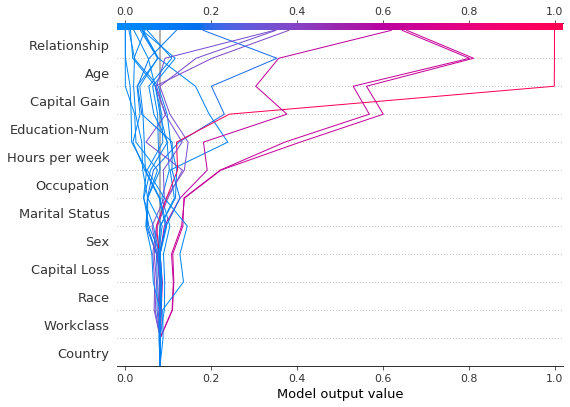

In [10]:
s = explainer.shap_values(X_test)
idx = np.argsort(np.sum(np.abs(s), axis=0))
del s
shap.decision_plot(explainer.expected_value, shap_values[:, idx], features.iloc[:, idx], 
                   link='logit', feature_order='none', matplotlib=True)

# SHAP interaction values
The decision plot supports SHAP interaction values as shown here. Notice that the lines do not completely converge to `explainer.expected_value` at the bottom of the plot. This is because there are N(N + 1)/2 = 12(13)/2 = 78 features including interaction and main effects. The decision plot shows only the 20 most important features by default. The next section explains how to control which features are displayed.

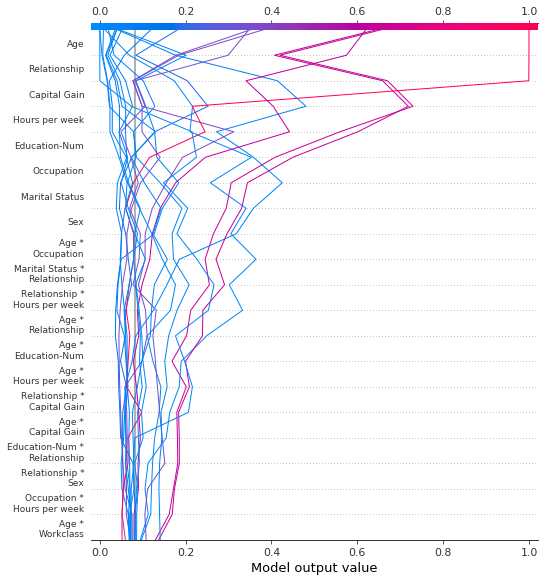

In [11]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, features, link='logit', matplotlib=True)

# Changing the display window
The decision plot provides parameters to define the x and y axes. The y-axis is defined using the `feature_display_range` parameter. It uses either a `range` or a `slice` object to specify which features are displayed after `feature_order` has been applied. By default, the plot uses `slice(None, -21, -1)` to show the last 20 features in descending order.

The `feature_display_range` parameter is particularly important when `'hclust'` ordering is applied. In this case, most of the important features are positioned at the beginning of the feature range. However, the decision plot shows the end of the feature range by default. The following plot shows the first 10 out of 78 SHAP interaction features using `'hclust'` ordering. **Note:** Because we show only the first 10 features, the observations do not strike the x-axis at their final predicted values. The snippet `feature_display_range=range(10, -1, -1)` indicates that we start at feature 10 and count to feature -1 by -1. The end point is not included in the range. Hence, we see the features 10 to 0.

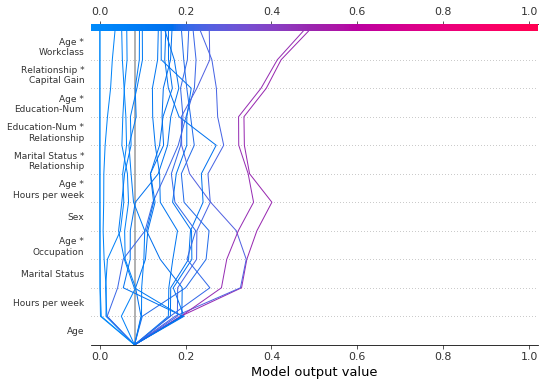

In [12]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=range(10, -1, -1),
                   matplotlib=True)

We can produce the same plot in ascending order by specifying an ascending range: `range(0, 11, 1)`.

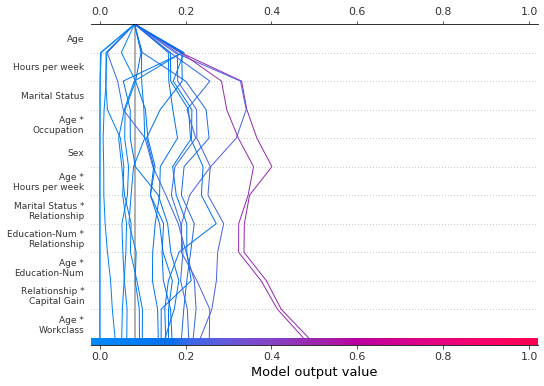

In [13]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=range(0, 11, 1),
                   matplotlib=True)

When selecting the last features in a range, it is usually more convenient to use a slice because slices support negative indices. For example, the index -20 indicates the 20th item from the end. The following plot shows the last 10 features in descending `'hclust'` order.

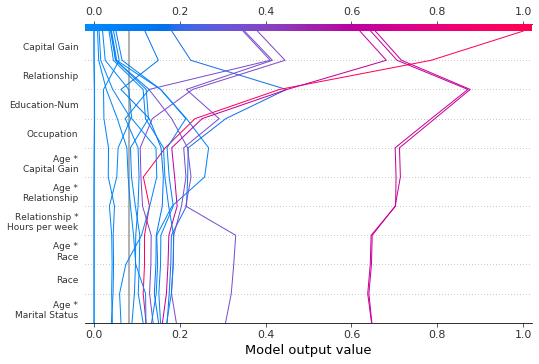

In [14]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=slice(None, -11, -1),
                   matplotlib=True)

We can display all available features in a number of ways. The simplest is `feature_display_range=slice(None, None, -1)`. **Note:** If your dataset contains many features, this will produce a very large plot.

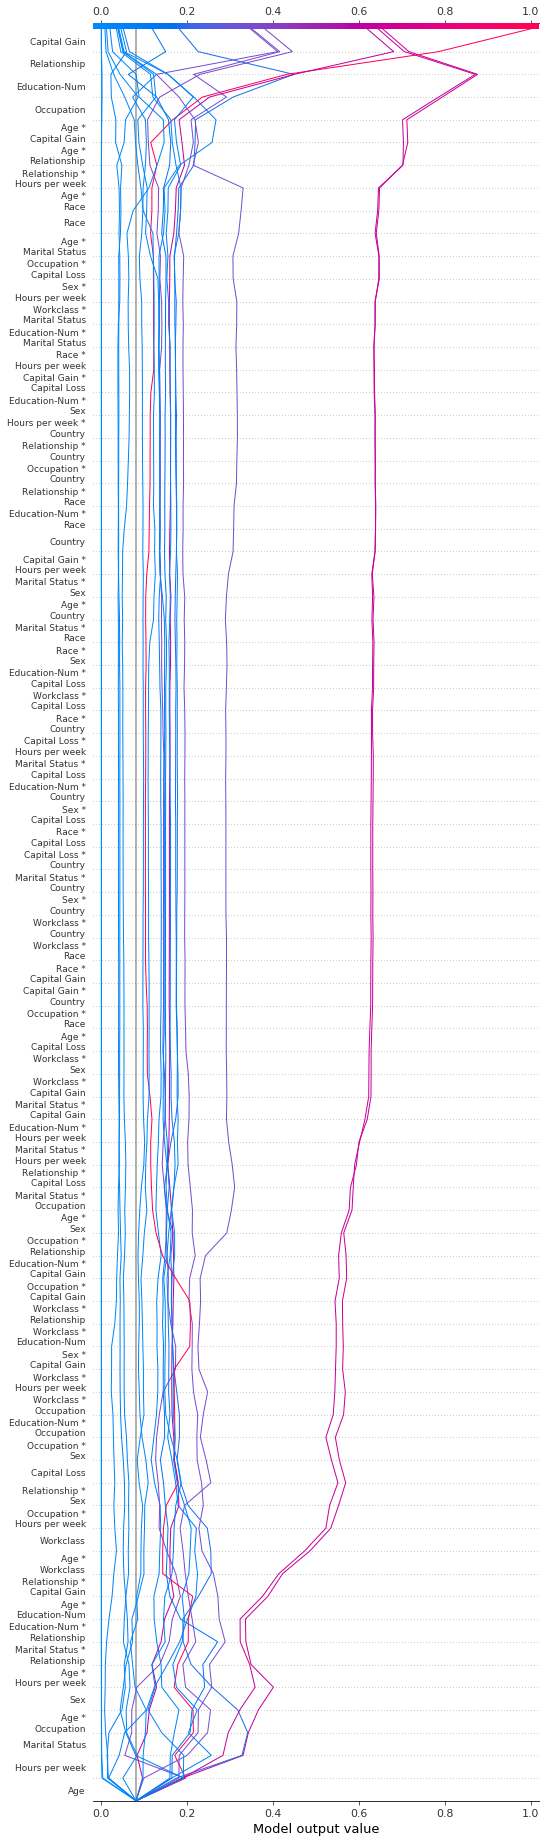

In [15]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, link='logit', feature_order='hclust', 
                   feature_display_range=slice(None, None, -1),
                   matplotlib=True)

Finally, we show how to specify the limits of the x-axis. This is useful to display several decision plots on the same scale for comparison. When `link='identity'` (the default), the decision plot adjusts the x-axis to the range of the plotted observations. (When `link='logit'` the x-axis limits are always `[0, 1]`).

The following code snippet shows the process of plotting two plots on the same scale.

(-15.46755994878599, 10.608166158327517)


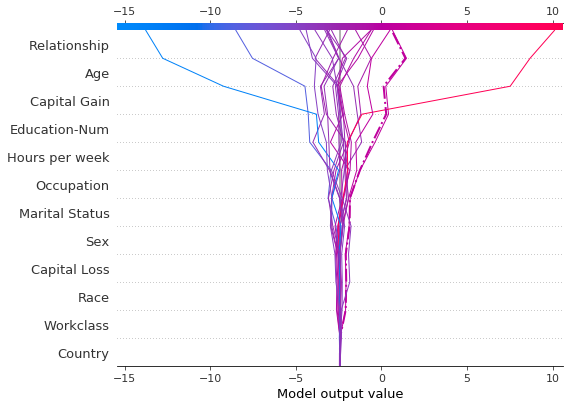

In [16]:
# Create a matplotlib plot, but don't show it immediately.
shap.decision_plot(explainer.expected_value, shap_values[:, idx], features_display.iloc[:, idx],
                   highlight=misclassified, matplotlib=True, show=False, feature_order='none')

# Retrieve the x-axis limits from matplotlib before displaying the plot.
import matplotlib.pyplot as plt
xlim = plt.gca().get_xlim()
print(xlim)
plt.show()

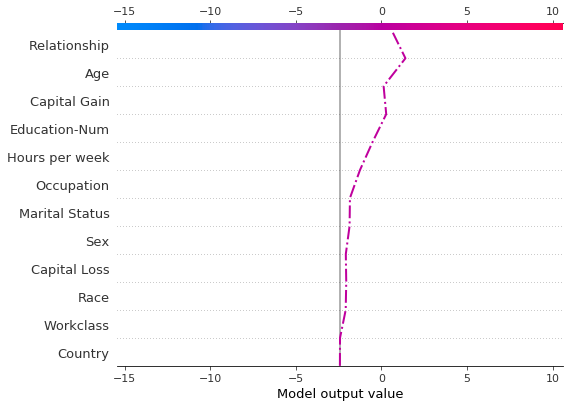

In [17]:
# Specify the x-axis limits for the next plot.
shap.decision_plot(explainer.expected_value, shap_values[misclassified, idx], 
                   features_display.iloc[misclassified, idx], highlight=[0], matplotlib=True, 
                   feature_order='none', xlim=xlim)

# Changing the plot's base value
SHAP values are relative to `explainer.expected_value`: the mean of the raw model predictions for the training data.

In [18]:
# The model's training mean
print(model.predict(X_train, raw_score=True).mean().round(4))

# The explainer expected value
print(explainer.expected_value.round(4))

-2.4297
-2.4297


To obtain correct prediction values, `explainer.expected_value` is added to the sum of SHAP values for each observation.

In [19]:
# The model's raw prediction for the first observation.
print(model.predict(features.iloc[[0]].values, raw_score=True)[0].round(4))

# The corresponding sum of the mean + shap values
print((shap_values[0].sum() + explainer.expected_value).round(4))

-3.1866
-3.1866


Hence, `explainer.expected_value` must be provided to the decision plot to produce correct predictions. Visually, `explainer.expected_value` is the starting value for each observation. This is not always intuitive. For example, if we set the cutoff value for our logistic classification problem to probability 0.4, it might make more sense to use the cutoff value as the base value for our plot. The following code shows how to shift the base value for the decision plot to an arbitrary value.

In [20]:
# Choose our new base value in raw model units (log-odds in our case).
p = 0.4  # Probability 0.4
base_value = np.log(p / (1 - p))  # the logit function

# Find the shift and apply it to the SHAP values.
shift = explainer.expected_value - base_value
shap_values_shifted = shap_values + shift / shap_values.shape[1]

# Show that the shifted predictions are the same as the original SHAP values.
pred_shap = (explainer.expected_value + shap_values.sum(1)).round(6)
pred_shifted = (base_value + shap_values_shifted.sum(1)).round(6)
print(all(pred_shap == pred_shifted))

True


Use the new base value...

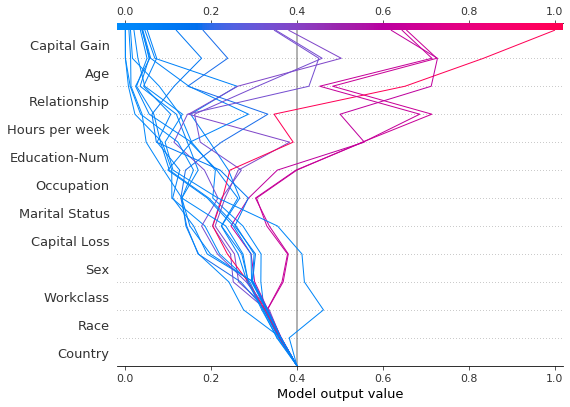

In [21]:
shap.decision_plot(base_value, shap_values_shifted, features_display, link='logit', matplotlib=True)